In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import cm
import astropy.coordinates as coord
from astropy import units as u
from astropy.table import QTable
from astropy.coordinates import FK5
coord.galactocentric_frame_defaults.set("latest")

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

In [52]:
#Oort constants by GAIA:
A = 15.3
dA = 0.4
B = -11.9
dB = 0.4

def proper_motion(pmra,pmdec):
    return np.sqrt(pmra**2 + pmdec**2)

def radius_to_gal(Ro,d,l):
    r=np.sqrt(Ro**2 +d**2 -(2*Ro*d*np.cos(np.radians(l))))
    return r

def distance_to_sun(Vr, l):
    A = 15.3
    return np.abs(Vr)/(A*np.sin(2*np.radians(l)))

def relative_tangental_vel(d,l):
    A = 15.3
    B = -11.9
    return d*((A*np.cos(2*np.radians(l)))+B)

#IT DOESN'T WORK
def total_vel(Vr, l, gal_sun_v, d):
    radial = Vr + gal_sun_v * np.sin(np.radians(l))
    tangential = relative_tangental_vel(d, l) + gal_sun_v * np.cos(np.radians(l))
    return np.sqrt(radial**2 + tangential**2)

def errors(a,b,c,d,e):
    dur=5
    dr=0.2
    rad_vel_er=(a/(b*np.sin(c)))*dur
    radius_er=np.abs((d-(b*np.cos(c)))*(e/a**2)*dr)
    total_er = np.sqrt((rad_vel_er)**2 + (radius_er)**2)
    return radius_er, total_er


In [54]:
data=pd.read_csv("/Users/User/Documents/ΠΑΝΑΓΙΩΤΑ/SOFTWARE_ASTRO/test2.txt",sep='\s+', header=None, skiprows=0, names=['l', 'b', 'radial_velocity', 'radius'])
data=data.drop('b', axis=1)
data['distance']=distance_to_sun(data['radial_velocity'], data['l'])
data['radius_cal']=radius_to_gal(8.5,data['distance'],data['l'])
data['tangential_velocity']=relative_tangental_vel(data['distance'],data['l'])
data['star_rad']=data['radial_velocity']+(240*np.sin(np.radians(data['l'])))
data['star_tang']=data['tangential_velocity']+(240*np.cos(np.radians(data['l'])))
data['total_vel']=np.sqrt(data['star_rad']**2 + data['star_tang']**2)
print(data)

     l  radial_velocity  radius   distance  radius_cal  tangential_velocity  \
0   35             -7.2     8.8   0.500790    8.094875            -3.338810   
1   35            -23.9     9.8   1.662343    7.201686           -11.082994   
2   35            -42.5    10.9   2.956049    6.310587           -19.708253   
3   50             -7.2     9.0   0.477848    8.201019            -6.955943   
4   50            -23.9    10.5   1.586189    7.578462           -23.089867   
5   50            -42.5    12.1   2.820629    7.027363           -41.059387   
6   65             -7.2     9.8   0.614309    8.259168           -13.351798   
7   65            -23.9    13.0   2.039166    7.858612           -44.320552   
8   65            -42.5    16.6   3.626131    7.703691           -78.812698   
9   44             -7.4     8.9   0.483955    8.158801            -5.500650   
10  44            -28.0    10.4   1.831181    7.294527           -20.813271   
11  44            -48.6    12.0   3.178407    6.5942

In [117]:
def polyex_model(R, a1, a2, theta0):
    return theta0 * (1 - np.exp(-R/a1)) * (1 + (a2 * R / a1))
popt, pcov = curve_fit(polyex_model, data['radius'], data['total_vel'], p0=[1, 0.003,240],bounds = ([1, 0.003, 0], [1.4, 0.006, np.inf]))
a1,a2,theta0 = popt
print(f"Fitted parameters - polyex: a1 = {a1}, a2 = {a2}")

def persic(R,a1,a2,a3,theta0):
    return theta0* a1*(1 + a2 * ((R / a3) - 1))
popt2, pcov2 = curve_fit(persic, data['radius'], data['total_vel'], p0=[1, 0.6,7,240], )
a4, a5, a6, theta1 = popt2
print(f"Fitted parameters - persic: a1 = {a4}, a2 = {a5}, a3={a6}")

def power_law(R,a1,a2,Ro,theta0):
    return theta0*a1*((R/Ro))**a2
popt3, pcov3 = curve_fit(power_law, data['radius'], data['total_vel'], p0=[1, 0.0394,8.5,240])
a7,a8,Ro,theta2 = popt3
print(f"Fitted parameters - power_law: a1 = {a7}, a2 = {a8}")

def polynomial(R,a1,a2,a3,Ro,theta0):
    return theta0*(a1+a2*((R/Ro)-1)+a3*(((R/Ro)-1)**2))
popt4, pcov4 = curve_fit(polynomial, data['radius'], data['total_vel'], p0=[1, 0.02,0,8.5,240],bounds = ([0.7, 0.02, 0, 1,200], [1.5, 0.1, 0.00001, 10,300]))
a9,a10, a11 ,Rs,theta3 = popt4
print(f"Fitted parameters - polynomial: a1 = {a9}, a2 = {a10}, a3={a11}")



Fitted parameters - polyex: a1 = 1.0000000000000067, a2 = 0.005544903996936036
Fitted parameters - persic: a1 = 0.8885766245602912, a2 = -0.012159041519678173, a3=-2.1659739434413403
Fitted parameters - power_law: a1 = 0.9929285686000691, a2 = 0.09182342512846055
Fitted parameters - polynomial: a1 = 0.9799818458765487, a2 = 0.02000000000003103, a3=9.999999999999999e-06


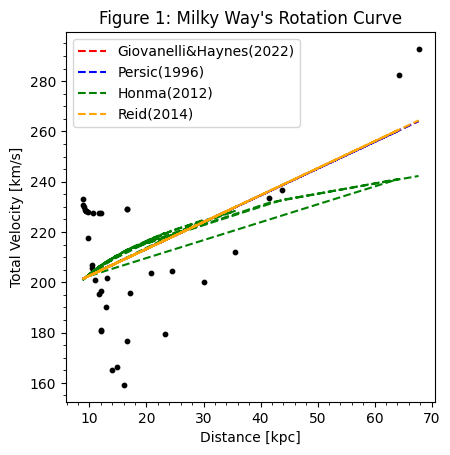

In [118]:
plt.scatter(data['radius'], data['total_vel'], color='black', s=10)
#plt.errorbar(data['radius'], data['total_vel'], xerr=data['r_error'], yerr=data['vel_error'], fmt='o', capsize=5, color='black')
plt.plot(data['radius'], polyex_model(data['radius'],*popt), color='red', label='Giovanelli&Haynes(2022)', linestyle='--')
plt.plot(data['radius'], persic(data['radius'], *popt2), color='blue', label='Persic(1996)', linestyle='--')
plt.plot(data['radius'], power_law(data['radius'], *popt3), color='green', label='Honma(2012)', linestyle='--')
plt.plot(data['radius'], polynomial(data['radius'], *popt4), color='orange', label='Reid(2014)', linestyle='--')

plt.title("Figure 1: Milky Way's Rotation Curve")
ax1=plt.gca()
ax1.set_xlabel("Distance [kpc]")
#ax1.set_xlim([0,50])
#ax1.set_ylim([0,250])
ax1.set_ylabel("Total Velocity [km/s]")
ax1.yaxis.get_ticklocs(minor=True)
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()
ax1.set_box_aspect(1.0)
plt.legend()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_5760\2806479711.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm', 256)


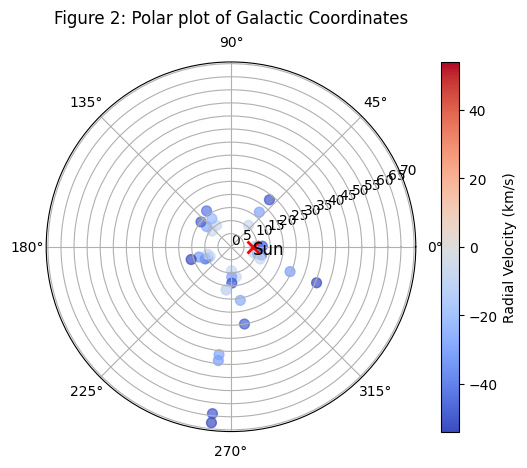

In [138]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

cmap = cm.get_cmap('coolwarm', 256)
norm = cm.colors.Normalize(vmin=np.min(data['radial_velocity']), vmax=np.abs(np.min((data['radial_velocity']))))

mapped_colors = cmap(norm(data['radial_velocity']))
ax.scatter(data['l'], data['radius'], s=50, alpha=0.7, color=mapped_colors)
ax.plot(0, 8.5,'x', color="red", markersize=8,markeredgewidth=2)
plt.text(0 -0.1, 8.5, "Sun", fontsize=12,verticalalignment='center')
ax.set_title('Figure 2: Polar plot of Galactic Coordinates', va='bottom')
custom_radii = [0, 5,10,15,20,25,30,35,40,45,50,55,60,65,70]
ax.set_rticks(custom_radii)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Radial Velocity (km/s)')